In [1]:
# import packages
import time
import csv
import pandas as pd
import numpy as np
from numpy.random import choice
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import rdkit.Chem.rdMolDescriptors 
from rdkit.Chem import Descriptors
from rdkit.Chem import GraphDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import sys
import gzip
from IPython.display import display
from IPython.display import Image
from PIL import Image as PILImage


The TSNE using Morgan fingerprints and Euclidian distance seems to have good separation of clusters without the need for Tanimoto similarity matrix

In [2]:
# Read in the file, excluding the 'SMILES' column
descriptors = pd.read_csv('docked_ecfp.csv')
column_to_exclude = 'SMILES'

# Check if the column to exclude exists
if column_to_exclude in descriptors.columns:
    # Drop the specified column
    df = descriptors.drop(column_to_exclude, axis=1)
else:
    df = descriptors.copy()  # If the column doesn't exist, create a copy of the DataFrame

# Extract the 'Name' column and set it as the index
compound_names = df['Name']
df = df.drop('Name', axis=1)  # Drop the 'Name' column from the DataFrame

# Convert DataFrame to numpy array
data = df.to_numpy()

# Now, 'compound_names' is a Series containing the names associated with each array of descriptors
# 'data' is a numpy array containing the descriptors

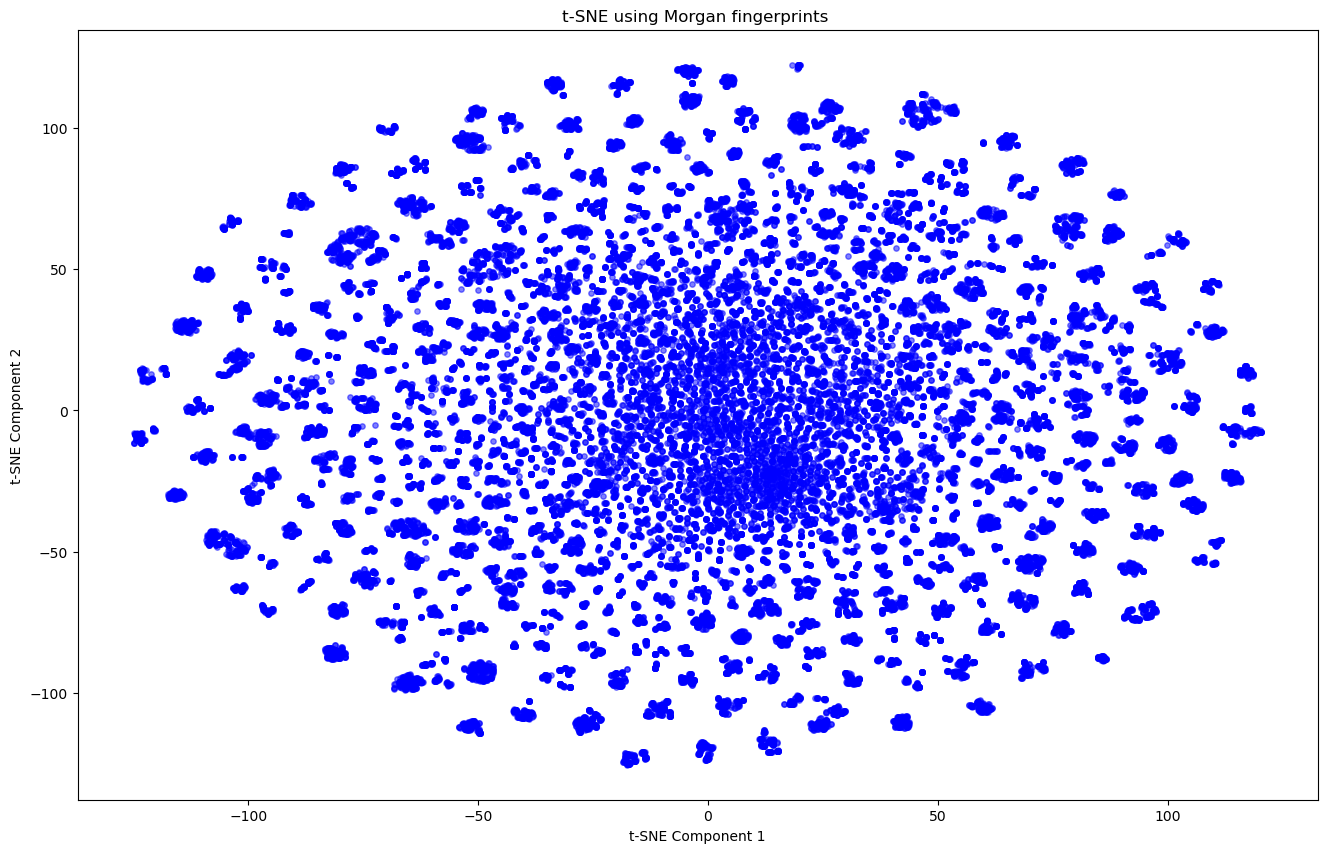

In [3]:
# t-sne embedding with Morgan fingerprints 
X = data  # samples with 2 features each

# Apply t-SNE dimensionality reduction
tsne = TSNE(n_components=2, init='random', random_state=1234)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(16, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='b', marker='o', s=15, alpha=0.5)

# Customize plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE using Morgan fingerprints ')

# Show the plot
plt.show()

In [4]:
lims2=[(-130,130),(-130,130)]
bins=[260,260]

counts2,edges2=np.histogramdd(X_tsne, bins=bins, range=lims2, density=False)

starts2=np.array([edges2[i][0] for i in range(2)])
steps2=np.array([(edges2[i][-1]-edges2[i][0])/(len(edges2[i])-1) for i in range(2)])

inds2=np.floor((X_tsne-starts2[np.newaxis,:])/steps2[np.newaxis,:]).astype(int)

probabilities2=1/counts2[inds2[:,0],inds2[:,1]]
probabilities2/=np.sum(probabilities2)

In [47]:
# I kept getting duplicated compounds using the code above so I decided to implement a way to ensure unique selections
n_picks = 25

# Use rejection sampling to ensure unique selections
unique_indices = set()
while len(unique_indices) < n_picks:
    new_index = np.random.choice(np.arange(len(probabilities2)), p=probabilities2)
    unique_indices.add(new_index)

draw_step_0 = np.array(list(unique_indices))
print(draw_step_0)
S2_sel = X_tsne[draw_step_0, :]

[38288  1940 18462 22441 32170 33456  5681 33204  2620  2877  8509   577
   970 38988 34893 24542  9828 17130  1003 23404  6506  9200 14332 21501
  8959]


In [48]:
# Use iloc to get compound names for the selected indices
selected_compound_names = compound_names.iloc[draw_step_0]

# Check for duplicates
duplicates_exist = selected_compound_names.duplicated().any()

if duplicates_exist:
    print("Duplicates exist in selected_compound_names.")
else:
    print("No duplicates found in selected_compound_names.")

# Now, 'selected_compound_names' contains the compound names for the selected indices
selected_compound_names

No duplicates found in selected_compound_names.


38288    NCGC00472512-01
1940     NCGC00376892-01
18462    NCGC00430884-01
22441    NCGC00439023-01
32170    NCGC00458575-01
33456    NCGC00461082-01
5681     NCGC00397347-01
33204    NCGC00460606-01
2620     NCGC00378189-01
2877     NCGC00391508-01
8509     NCGC00410477-01
577      NCGC00374337-01
970      NCGC00375137-01
38988    NCGC00474077-01
34893    NCGC00463829-01
24542    NCGC00443115-01
9828     NCGC00413031-01
17130    NCGC00428261-01
1003     NCGC00375178-01
23404    NCGC00440818-01
6506     NCGC00399246-01
9200     NCGC00411844-01
14332    NCGC00422787-01
21501    NCGC00437057-01
8959     NCGC00411377-01
Name: Name, dtype: object

In [49]:
# Assuming 'selected_compound_names' is a pandas Series or DataFrame
duplicates_mask = selected_compound_names.duplicated(keep=False)  # Mark all occurrences as duplicates
duplicates = selected_compound_names[duplicates_mask]

if not duplicates.empty:
    print("Duplicates found in selected_compound_names:")
    print(duplicates)
else:
    print("No duplicates found in selected_compound_names.")

No duplicates found in selected_compound_names.


In [50]:
# Assuming 'original_descriptors.csv' is the original file
original_descriptors = pd.read_csv('docked_ecfp.csv')

# Merge the original DataFrame with the 'selected_compound_names' Series
merged_df = pd.merge(original_descriptors, selected_compound_names, on='Name')

# The resulting 'merged_df' contains the original descriptors for the selected compounds
selected_compound_info = merged_df.drop_duplicates(subset=['Name'])  # Drop duplicates if any

# Save the selected compounds to a new CSV file
selected_compound_info.to_csv('ecfp_euclidean_set/new/round0_25_ecfp.csv', index=False)

Double check that these newly chosen compounds are different than the compounds from sample1

In [54]:
# Load the first CSV file into a DataFrame
df1 = pd.read_csv('ecfp_euclidean_set/new/greedy/weighted_random/1/round0_10_ecfp.csv')
#df1 = pd.read_csv('test/test_2D_descriptors.csv')

# Load the second CSV file into another DataFrame
df2 = pd.read_csv('ecfp_euclidean_set/new/round0_25_ecfp.csv')
#df2 = pd.read_csv('ecfp_euclidean_set/new/round0_100_ecfp.csv')

# Preprocess 'Name' columns
df1['Name'] = df1['Name'].str.strip().str.lower()
df2['Name'] = df2['Name'].str.strip().str.lower()

# Get unique compounds in each file
unique_compounds_df1 = set(df1['Name'])
unique_compounds_df2 = set(df2['Name'])

# Get common compounds
common_compounds = unique_compounds_df1.intersection(unique_compounds_df2)

# Display results
print("\nCommon compounds:", common_compounds)


Common compounds: set()
